# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [2]:
! git clone https://github.com/ds4e/wrangling

Cloning into 'wrangling'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 63 (delta 9), reused 6 (delta 6), pack-reused 39 (from 1)
Receiving objects: 100% (63/63), 13.84 MiB | 6.74 MiB/s, done.
Resolving deltas: 100% (14/14), done.


Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(62, 6)


OSError: Cannot save file into a non-existent directory: 'src'

With the data in and wrangled, we can now do some analysis:

count       46.000000
mean     11983.630435
std      13656.112410
min       2000.000000
25%       4037.500000
50%       6725.000000
75%      13350.000000
max      62800.000000
Name: price, dtype: float64


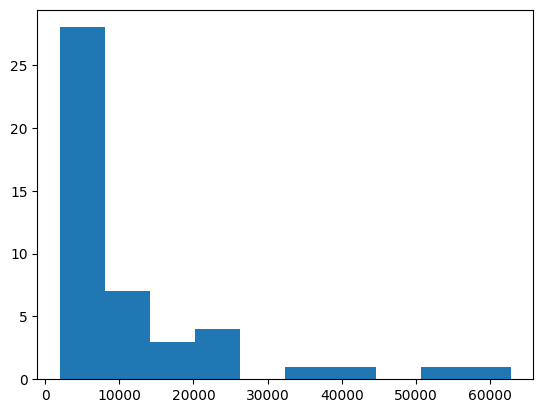

count    41.000000
mean     24.121951
std      16.315936
min       6.000000
25%      13.000000
50%      19.000000
75%      31.000000
max      68.000000
Name: age, dtype: float64


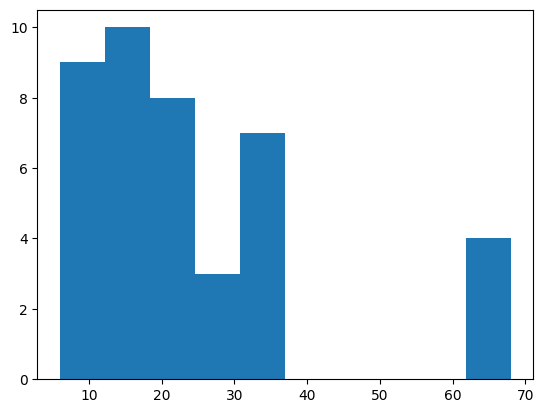

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
audi         1.0  37000.000000           NaN  37000.0  37000.00  37000.0   
bmw          3.0  19966.666667  20813.537261   7900.0   7950.00   8000.0   
chevrolet    4.0  10875.000000   9393.038202   3000.0   3375.00   9000.0   
chevy        3.0  11616.666667  11515.677719   4450.0   4975.00   5500.0   
dodge        1.0  18900.000000           NaN  18900.0  18900.00  18900.0   
ford         3.0  21333.333333  29173.332572   3500.0   4500.00   5500.0   
gmc          2.0  16475.000000  13470.384182   6950.0  11712.50  16475.0   
honda        5.0   5629.800000   2372.328013   2300.0   4700.00   5900.0   
jeep         2.0   9500.000000      0.000000   9500.0   9500.00   9500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.50  11175.0   
missing     14.0  10089.214286  16148.241324   2000.0   3312.50   4650.0   
mitsubishi   1.0   7300.000000           NaN   7300.0   7300.00   7300.0   
subaru       1.0   3900.000000           NaN   3900.0   3900.00   3900.0   
toyota       4.0   9549.750000   7072.121340   2199.0   4299.75   9500.0   

                               
                 75%      max  
brand                          
audi        37000.00  37000.0  
bmw         26000.00  44000.0  
chevrolet   16500.00  22500.0  
chevy       15200.00  24900.0  
dodge       18900.00  18900.0  
ford        30250.00  55000.0  
gmc         21237.50  26000.0  
honda        6500.00   8749.0  
jeep         9500.00   9500.0  
lexus       11287.50  11400.0  
missing      6749.75  62800.0  
mitsubishi   7300.00   7300.0  
subaru       3900.00   3900.0  
toyota      14750.00  17000.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                    
           count       mean        std   min   25%   50%   75%   max
brand                                                               
audi         1.0   6.000000        NaN   6.0   6.0   6.0   6.0   6.0
bmw          2.0  15.000000   1.414214  14.0  14.5  15.0  15.5  16.0
chevrolet    4.0  44.000000  16.000000  36.0  36.0  36.0  44.0  68.0
chevy        3.0  20.000000  12.124356   7.0  14.5  22.0  26.5  31.0
dodge        1.0  27.000000        NaN  27.0  27.0  27.0  27.0  27.0
ford         3.0  22.666667   1.154701  22.0  22.0  22.0  23.0  24.0
gmc          1.0  27.000000        NaN  27.0  27.0  27.0  27.0  27.0
honda        5.0  18.000000   9.000000  10.0  13.0  15.0  19.0  33.0
jeep         2.0  22.000000  14.142136  12.0  17.0  22.0  27.0  32.0
lexus        2.0  17.000000   5.656854  13.0  15.0  17.0  19.0  21.0
missing     11.0  30.636364  23.585049   7.0  12.0  20.0  49.0  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.0  17.0  17.0  17.0
subaru       1.0  11.000000        NaN  11.0  11.0  11.0  11.0  11.0
toyota       4.0  15.500000   3.109126  12.0  13.5  15.5  17.5  19.0

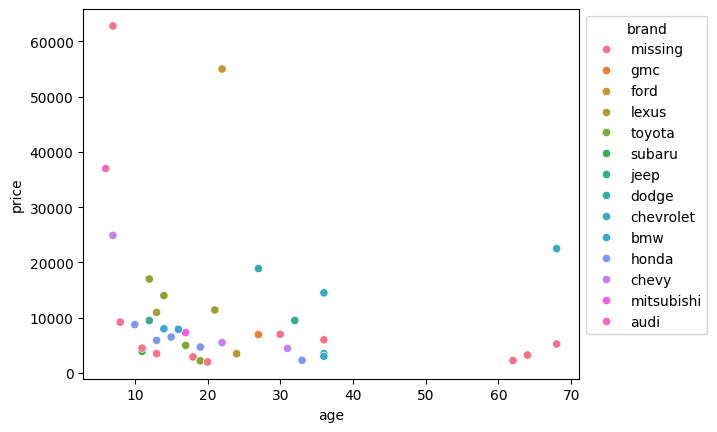

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.783367 -0.196806
log_age    -0.196806  0.382606
           log_price   log_age
log_price   1.000000 -0.376511
log_age    -0.376511  1.000000


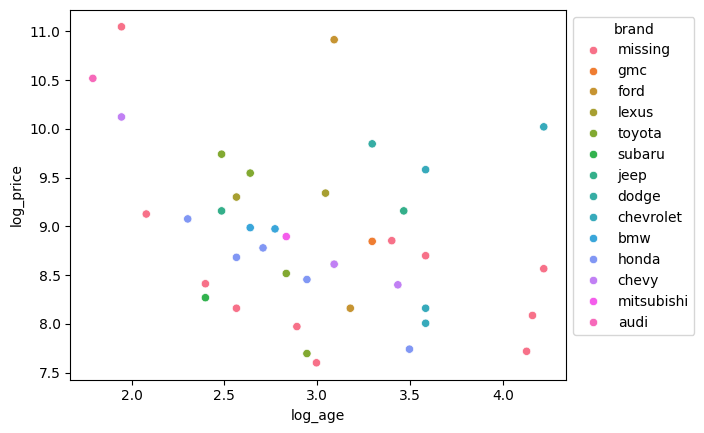

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

Real Estate for Sale in Maine
https://maine.craigslist.org/search/rea?housing_type=6#search=1~gallery~0~0
I want to gather information on location, price, and description
Basic EDA: price as it relates to location and description.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://maine.craigslist.org/search/rea?housing_type=6#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [82]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [100]:
import re # Regular expressions


house_types = ['foreclosure','farm','cabin','multi-family','multi-story','refurbished',
               'family','country','view', 'remodeled', 'renovated','pond',
               'lake','water','mountain','town','land'
               ,'riverfront','waterfront','barn','farmhouse','ranch','commercial']
# house types are some key words in the title that distinguish different types of homes
#water = ['pond','waterfront','riverfront']
#farm = ['farm','farmhouse','barn']


data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower().strip()
    price = listings[k].find('div',class_='price').get_text()
    location_tag = listings[k].find('div', class_='location')
    location = location_tag.get_text() if location_tag else "missing"
    link = listings[k].find(href=True)['href']
    # Get house type from the title string:
    words = title.split()
    hits = [word for word in words if word in house_types] # Find type in the title
    if len(hits) == 0:
        house_type = 'house' #if the title does not match a key word, it is generalized as a house
    else:
        house_type = hits[0]
    data.append({'title':title,'price':price,'location':location,'link':link,'house_type':house_type})


In [101]:
df = pd.DataFrame.from_dict(data)
df.tail(10)

,title,price,location,link,house_type
72,home for sale in virginia,"$740,000",\n Charlottesville\n ...,https://maine.craigslist.org/reb/d/charlottesv...,house
73,gorgeous historic farm,"$1,750,000",\n Gorham\n ...,https://maine.craigslist.org/reo/d/gorham-gorg...,farm
74,remodeled home on a dead end street,"$229,000",\n Livermore Falls\n ...,https://maine.craigslist.org/reb/d/livermore-f...,remodeled
75,🏡🏡 listing in windham 🏡🏡,"$725,000","\n 6 Sterling Drive, Wi...",https://maine.craigslist.org/reb/d/westbrook-l...,house
76,great invest for hotel,"$399,000",\n Rumford\n ...,https://maine.craigslist.org/reb/d/rumford-gre...,house
77,🏡🏡 listing in mount vernon 🏡🏡,"$299,900","\n 548 North Road, Moun...",https://maine.craigslist.org/reb/d/mount-verno...,house
78,"small home, large lot in town bethel minutes t...","$579,999",\n Bethel\n ...,https://maine.craigslist.org/reo/d/bethel-smal...,town
79,farm home for sale,"$489,000",\n harmony\n ...,https://maine.craigslist.org/reo/d/harmony-far...,farm
80,"kittery home for sale, completely refurbished!","$574,900",\n Kittery\n ...,https://maine.craigslist.org/reo/d/kittery-kit...,house
81,🏡🏡 new listing in augusta 🏡🏡,"$199,900","\n 7 Washington Street,...",https://maine.craigslist.org/reb/d/augusta-new...,house


In [102]:
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')

In [103]:
print(df.shape)
df.to_csv('/content/wrangling/lab/craigslist_maine_homes.csv') # Save data in case of a disaster
df.head()

(82, 5)


,title,price,location,link,house_type
0,"54 a to z rd, greene me 04236",415000,\n Greene\n ...,https://maine.craigslist.org/reb/d/greene-54-t...,house
1,🏡 🏡 new price in edgecomb 🏡 🏡,789000,"\n 301 Dodge Road, Edge...",https://maine.craigslist.org/reb/d/edgecomb-ne...,house
2,🏡🏡 listing in mount vernon 🏡🏡,189900,"\n ​1071 Bean Road​, Mo...",https://maine.craigslist.org/reb/d/mount-verno...,house
3,🏡🏡 new listing in mount vernon 🏡🏡,249900,"\n 1070 Bean Road, Moun...",https://maine.craigslist.org/reb/d/mount-verno...,house
4,🏡🏡 new price in brooks 🏡🏡,385000,\n Brooks\n ...,https://maine.craigslist.org/reb/d/brooks-new-...,house


In [104]:
df['location']= df['location'].str.strip()
df['location']=df['location'].str.lower()
df.head()

,title,price,location,link,house_type
0,"54 a to z rd, greene me 04236",415000,greene,https://maine.craigslist.org/reb/d/greene-54-t...,house
1,🏡 🏡 new price in edgecomb 🏡 🏡,789000,"301 dodge road, edgecomb, maine",https://maine.craigslist.org/reb/d/edgecomb-ne...,house
2,🏡🏡 listing in mount vernon 🏡🏡,189900,"​1071 bean road​, mount vernon, maine",https://maine.craigslist.org/reb/d/mount-verno...,house
3,🏡🏡 new listing in mount vernon 🏡🏡,249900,"1070 bean road, mount vernon, maine",https://maine.craigslist.org/reb/d/mount-verno...,house
4,🏡🏡 new price in brooks 🏡🏡,385000,brooks,https://maine.craigslist.org/reb/d/brooks-new-...,house


In [105]:
towns = []
for entry in df['location']:
    parts = entry.split(", ")  # Split by ", "

    if ("maine" or "me") in entry and len(parts) > 1:
        town = parts[-2]  # Get the second-to-last part (town name)
        towns.append(town)
    else:
        towns.append(entry)  # Keep original if not an address

# Print extracted town names
#print(towns)
df['town']=towns
df.head()
#chat gpt helped me with this structure

,title,price,location,link,house_type,town
0,"54 a to z rd, greene me 04236",415000,greene,https://maine.craigslist.org/reb/d/greene-54-t...,house,greene
1,🏡 🏡 new price in edgecomb 🏡 🏡,789000,"301 dodge road, edgecomb, maine",https://maine.craigslist.org/reb/d/edgecomb-ne...,house,edgecomb
2,🏡🏡 listing in mount vernon 🏡🏡,189900,"​1071 bean road​, mount vernon, maine",https://maine.craigslist.org/reb/d/mount-verno...,house,mount vernon
3,🏡🏡 new listing in mount vernon 🏡🏡,249900,"1070 bean road, mount vernon, maine",https://maine.craigslist.org/reb/d/mount-verno...,house,mount vernon
4,🏡🏡 new price in brooks 🏡🏡,385000,brooks,https://maine.craigslist.org/reb/d/brooks-new-...,house,brooks


In [106]:
df = df.rename(columns={
    'house_type': 'description',
    'location': 'address'
})

In [107]:
df.tail(30)

,title,price,address,link,description,town
52,multi-level building main st.,900000,vassalboro,https://maine.craigslist.org/reb/d/north-vassa...,house,vassalboro
53,beautiful home moose run dr.,1350000,monmouth,https://maine.craigslist.org/reb/d/monmouth-be...,house,monmouth
54,house for sale washington st.,1500000,bath,https://maine.craigslist.org/reb/d/bath-house-...,house,bath
55,home for sale mayflower rd.,575000,hallowell,https://maine.craigslist.org/reb/d/hallowell-h...,house,hallowell
56,mountain view near skiing,300000,west paris,https://maine.craigslist.org/reo/d/west-paris-...,mountain,west paris
57,large family home fixer upper,57500,fort fairfield,https://maine.craigslist.org/reo/d/fort-fairfi...,family,fort fairfield
58,spectacular views of big rock mountain,59500,blaine,https://maine.craigslist.org/reo/d/blaine-spec...,mountain,blaine
59,country home in northern maine,67500,littleton,https://maine.craigslist.org/reo/d/houlton-cou...,country,littleton
60,fixer upper on 1 acre,49500,fort fairfield,https://maine.craigslist.org/reo/d/fort-fairfi...,house,fort fairfield
61,"find a home, the easy way - multi-family home...",399000,missing,https://maine.craigslist.org/reb/d/find-home-t...,multi-family,missing


Visualization and Analysis

In [108]:
median_price_per_town = df.groupby('town')['price'].median()
#print(median_price_per_town)

df.loc[:,['price','town']].groupby('town').describe()


price                                          \
                              count          mean            std        min   
town                                                                          
14 porter st. searsport         1.0  3.500000e+05            NaN   350000.0   
28 drummond ave waterville me   1.0  2.950000e+05            NaN   295000.0   
745 lebanon street sanford me   1.0  2.850000e+05            NaN   285000.0   
auburn                          1.0  3.100000e+05            NaN   310000.0   
augusta                         4.0  2.024500e+05  103369.902131    60000.0   
baileyville                     1.0  0.000000e+00            NaN        0.0   
bath                            1.0  1.500000e+06            NaN  1500000.0   
bethel                          1.0  5.799990e+05            NaN   579999.0   
blaine                          1.0  5.950000e+04            NaN    59500.0   
bradford                        1.0  1.390000e+05            NaN   139000.0   
brooks                          1.0  3.850000e+05            NaN   385000.0   
cambridge                       1.0  4.250000e+05            NaN   425000.0   
carmel                          1.0  3.700000e+05            NaN   370000.0   
casco                           1.0  0.000000e+00            NaN        0.0   
charlottesville                 1.0  7.400000e+05            NaN   740000.0   
chelsea                         1.0  4.859000e+05            NaN   485900.0   
edgecomb                        1.0  7.890000e+05            NaN   789000.0   
farmingdale                     1.0  1.600000e+05            NaN   160000.0   
farmington                      1.0  1.650000e+05            NaN   165000.0   
fort fairfield                  2.0  5.350000e+04    5656.854249    49500.0   
gorham                          1.0  1.750000e+06            NaN  1750000.0   
grand isle                      1.0  5.299500e+04            NaN    52995.0   
greene                          1.0  4.150000e+05            NaN   415000.0   
hallowell                       3.0  6.533333e+05  512013.997205   185000.0   
harmony                         1.0  4.890000e+05            NaN   489000.0   
hermon                          1.0  0.000000e+00            NaN        0.0   
jay                             1.0  0.000000e+00            NaN        0.0   
kittery                         1.0  5.749000e+05            NaN   574900.0   
littleton                       1.0  6.750000e+04            NaN    67500.0   
livermore falls                 1.0  2.290000e+05            NaN   229000.0   
madison                         1.0  2.699000e+05            NaN   269900.0   
merrill                         2.0  1.999500e+05  212202.745034    49900.0   
missing                        11.0  2.045455e+05  183121.469870        0.0   
monmouth                        1.0  1.350000e+06            NaN  1350000.0   
monroe                          1.0  1.470000e+05            NaN   147000.0   
moscow                          1.0  8.900000e+04            NaN    89000.0   
mount vernon                    3.0  2.465667e+05   55075.705473   189900.0   
new portland                    1.0  3.590000e+05            NaN   359000.0   
north anson                     1.0  3.600000e+05            NaN   360000.0   
oakfield                        2.0  5.125000e+05  265165.042945   325000.0   
patten                          1.0  1.350000e+05            NaN   135000.0   
plymouth                        1.0  0.000000e+00            NaN        0.0   
portland                        2.0  0.000000e+00       0.000000        0.0   
presque isle                    2.0  2.000000e+05  282842.712475        0.0   
randolph                        1.0  2.000000e+05            NaN   200000.0   
readfield                       1.0  4.350000e+05            NaN   435000.0   
rumford                         1.0  3.990000e+05            NaN   399000.0   
sabattus                        1.0  4.490000e+05            NaN   449000.0   
s

In [109]:
number_houses_per_town = df['town'].value_counts().head(20)
print(number_houses_per_town)
# some towns only have 1 home

town
missing                          11
augusta                           4
mount vernon                      3
hallowell                         3
portland                          2
fort fairfield                    2
presque isle                      2
merrill                           2
oakfield                          2
winslow                           2
gorham                            1
west paris                        1
bradford                          1
patten                            1
harmony                           1
carmel                            1
28 drummond ave waterville me     1
grand isle                        1
vassalboro                        1
monmouth                          1
Name: count, dtype: int64


In [110]:
medianpricebytown = df.loc[:,['price','town']].groupby('town').median()
medianpricebytown_sorted = medianpricebytown.sort_values(by='price', ascending=False).head(15)
print(medianpricebytown_sorted)
# we see that gorham, bath, and monmouth have the most expensive homes in our dataset

                     price
town                      
gorham           1750000.0
bath             1500000.0
monmouth         1350000.0
wayne             900000.0
vassalboro        900000.0
skowhegan         879900.0
edgecomb          789000.0
charlottesville   740000.0
windham           725000.0
bethel            579999.0
hallowell         575000.0
kittery           574900.0
oakfield          512500.0
harmony           489000.0
chelsea           485900.0


In [111]:
# creating a function to classify and group together similar homes (town, rural, by water, etc.)
def classify_home_type(description):
    if 'waterfront' in description or 'riverfront' in description or 'pond' in description:
        return 'near water'
    elif 'cabin' in description or 'mountain' in description:
        return 'cabin'
    elif 'town' in description:
        return 'town house'
    elif 'farm' in description or 'farmhouse' in description or 'ranch' in description or 'barn' in description or 'country' in description:
        return 'rural/farm'
    elif 'foreclosure' in description:
        return 'foreclosure'
    else:
        return 'other'

# Create a new column for the home type
df['home_type'] = df['description'].apply(classify_home_type)

In [112]:
medianpricebytype = df.loc[:,['price','home_type']].groupby('home_type').median()
medianpricebytype_sorted = medianpricebytype.sort_values(by='price', ascending=False)
print(medianpricebytype_sorted)
# we see that town houses have the higher median prices

                price
home_type            
town house   579999.0
near water   449500.0
other        295000.0
rural/farm   232000.0
cabin        179750.0
foreclosure       0.0


<ipython-input-113-6667072bfb26>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_prices.index, y=median_prices.values, palette='viridis')


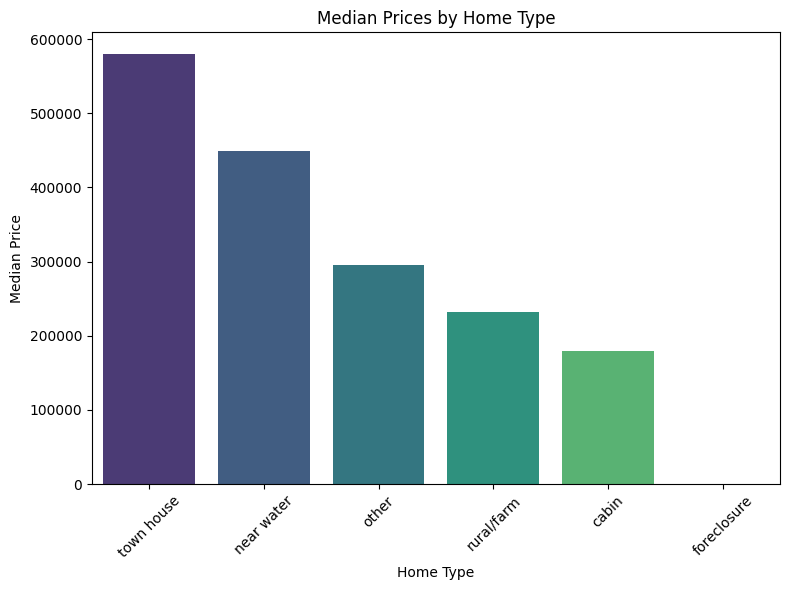

In [113]:

# Group by 'home_type' and calculate the median price
median_prices = df.groupby('home_type')['price'].median().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(x=median_prices.index, y=median_prices.values, palette='viridis')
plt.title('Median Prices by Home Type')
plt.xlabel('Home Type')
plt.ylabel('Median Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# from this plot we see that town house and waterfront houses are more expensive and rural/farm/cabin houses are less expensive

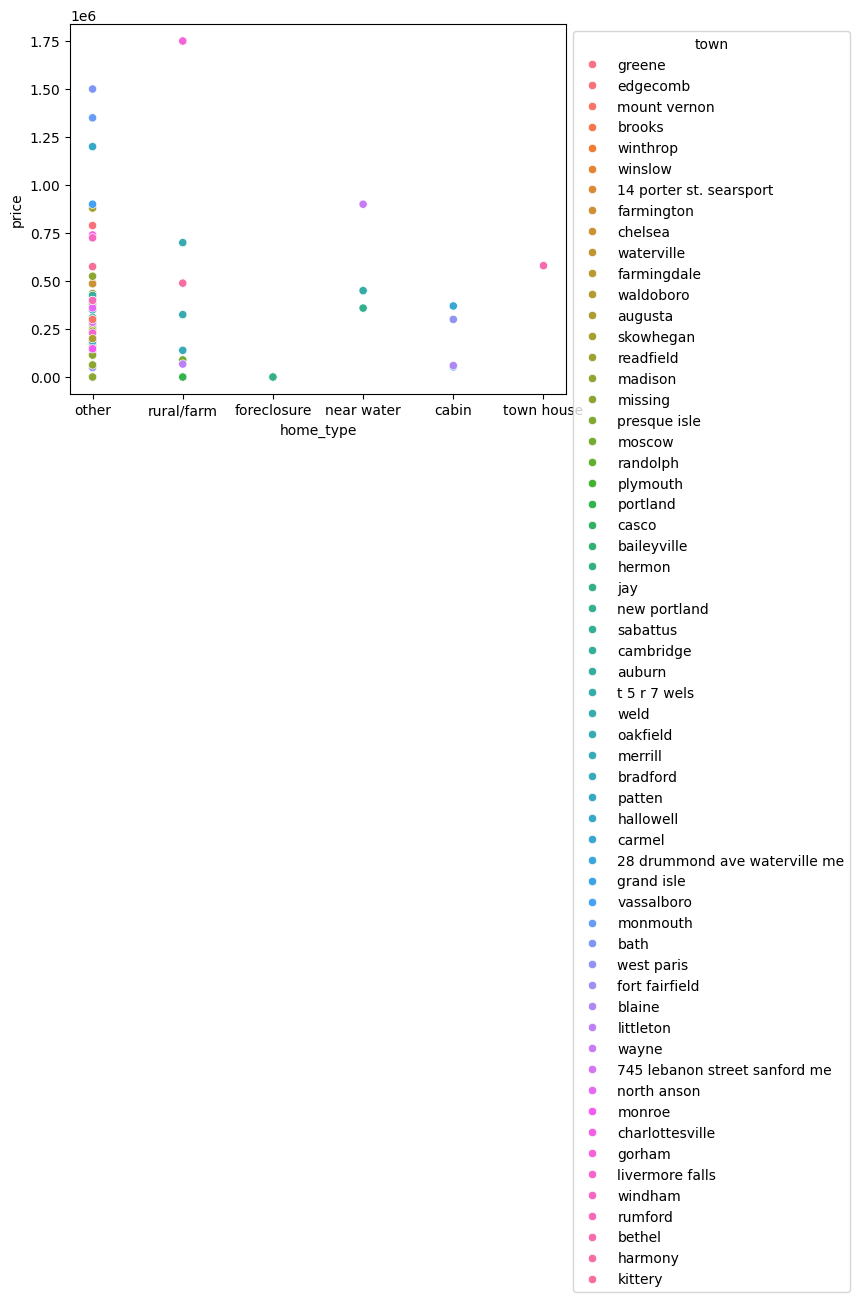

In [114]:
# home type and town
# scatterplot with frequency of home type in dataset - y axis is count or proportion
# colored by town?

ax = sns.scatterplot(data=df, x='home_type', y='price',hue='town')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# not a super meaningful plot